In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from torchvision import datasets, transforms, models

In [22]:
class_names = ['Lung benign tissue', 'Lung adenocarcinoma', 'Lung squamous cell carcinoma', 'Colon adenocarcinoma', 'Colon benign tissue']

class_num = 5

In [23]:
for c in class_names:
    os.makedirs('./train_dir/' + c, exist_ok = True)
    os.makedirs('./test_dir/' + c, exist_ok = True)
    os.makedirs('./val_dir/' + c, exist_ok = True)

In [24]:

image_files = []
filenum_per_class = 1000
for i in ['./colon_image_sets/colon_aca/', 'colon_image_sets/colon_n/', './lung_image_sets/lung_aca/', 'lung_image_sets/lung_n/', 'lung_image_sets/lung_scc/']:
    k = 0
    for j in os.listdir(i):
        if k < filenum_per_class:
            image_files.append(i+j)
            k += 1
        else:
            break
               
print(image_files)

['./colon_image_sets/colon_aca/colonca19.jpeg', './colon_image_sets/colon_aca/colonca190.jpeg', './colon_image_sets/colon_aca/colonca1900.jpeg', './colon_image_sets/colon_aca/colonca1901.jpeg', './colon_image_sets/colon_aca/colonca1902.jpeg', './colon_image_sets/colon_aca/colonca1903.jpeg', './colon_image_sets/colon_aca/colonca1904.jpeg', './colon_image_sets/colon_aca/colonca1905.jpeg', './colon_image_sets/colon_aca/colonca1906.jpeg', './colon_image_sets/colon_aca/colonca1907.jpeg', './colon_image_sets/colon_aca/colonca1908.jpeg', './colon_image_sets/colon_aca/colonca1909.jpeg', './colon_image_sets/colon_aca/colonca191.jpeg', './colon_image_sets/colon_aca/colonca1910.jpeg', './colon_image_sets/colon_aca/colonca1911.jpeg', './colon_image_sets/colon_aca/colonca1912.jpeg', './colon_image_sets/colon_aca/colonca1913.jpeg', './colon_image_sets/colon_aca/colonca1914.jpeg', './colon_image_sets/colon_aca/colonca1915.jpeg', './colon_image_sets/colon_aca/colonca1916.jpeg', './colon_image_sets/col

In [8]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [12]:
# Prepare training, validation, and test data lists
valid_frac, test_frac = 0.09, 0.1
trainX = []
valX = []
testX = []

for k in range(5):
    rann = 0
    for i in range(filenum_per_class):
        j = image_files[filenum_per_class*k+i]
        r = j.split('/')[-1]
        # l = Image.open(j)
        # l = l.resize((224,224))
        if rann < test_frac:
            testX.append(image_files[filenum_per_class*k+i])
            shutil.move(j,f'./test_dir/{class_names[k]}/{r}')
        elif rann < test_frac + valid_frac:
            valX.append(image_files[filenum_per_class*k+i])
            shutil.move(j,f'./val_dir/{class_names[k]}/{r}')
        else:
            trainX.append(image_files[filenum_per_class*k+i])  
            shutil.move(j,f'./train_dir/{class_names[k]}/{r}')
        rann += 1./filenum_per_class
    
print(len(trainX), len(valX), len(testX))
print(trainX)

4050 450 500
['./colon_image_sets/colon_aca/colonca117.jpeg', './colon_image_sets/colon_aca/colonca1170.jpeg', './colon_image_sets/colon_aca/colonca1171.jpeg', './colon_image_sets/colon_aca/colonca1172.jpeg', './colon_image_sets/colon_aca/colonca1173.jpeg', './colon_image_sets/colon_aca/colonca1174.jpeg', './colon_image_sets/colon_aca/colonca1175.jpeg', './colon_image_sets/colon_aca/colonca1176.jpeg', './colon_image_sets/colon_aca/colonca1177.jpeg', './colon_image_sets/colon_aca/colonca1178.jpeg', './colon_image_sets/colon_aca/colonca1179.jpeg', './colon_image_sets/colon_aca/colonca118.jpeg', './colon_image_sets/colon_aca/colonca1180.jpeg', './colon_image_sets/colon_aca/colonca1181.jpeg', './colon_image_sets/colon_aca/colonca1182.jpeg', './colon_image_sets/colon_aca/colonca1183.jpeg', './colon_image_sets/colon_aca/colonca1184.jpeg', './colon_image_sets/colon_aca/colonca1185.jpeg', './colon_image_sets/colon_aca/colonca1186.jpeg', './colon_image_sets/colon_aca/colonca1187.jpeg', './colon

In [81]:

train_dir = './train_dir'
test_dir = './test_dir'
val_dir = './val_dir'
batch_size = 4

# TODO: Load the datasets with imageFolder
image_datasets = {}
image_datasets["train"] = datasets.ImageFolder(root = train_dir, transform=train_transforms)
image_datasets["valid"] = datasets.ImageFolder(root = val_dir, transform=test_transforms)
image_datasets["test"] = datasets.ImageFolder(root = test_dir, transform=test_transforms)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

# TODO: Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle = True,
                                          num_workers = 2)
valid_loader = torch.utils.data.DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle = False,
                                          num_workers = 2)
test_loader = torch.utils.data.DataLoader(image_datasets["test"], batch_size=batch_size, shuffle = False,
                                         num_workers = 2)

print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 4050, 'valid': 450, 'test': 500}
cuda:0


In [82]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [27]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = class_names[labels[i]]
        ax.set_title(label)
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

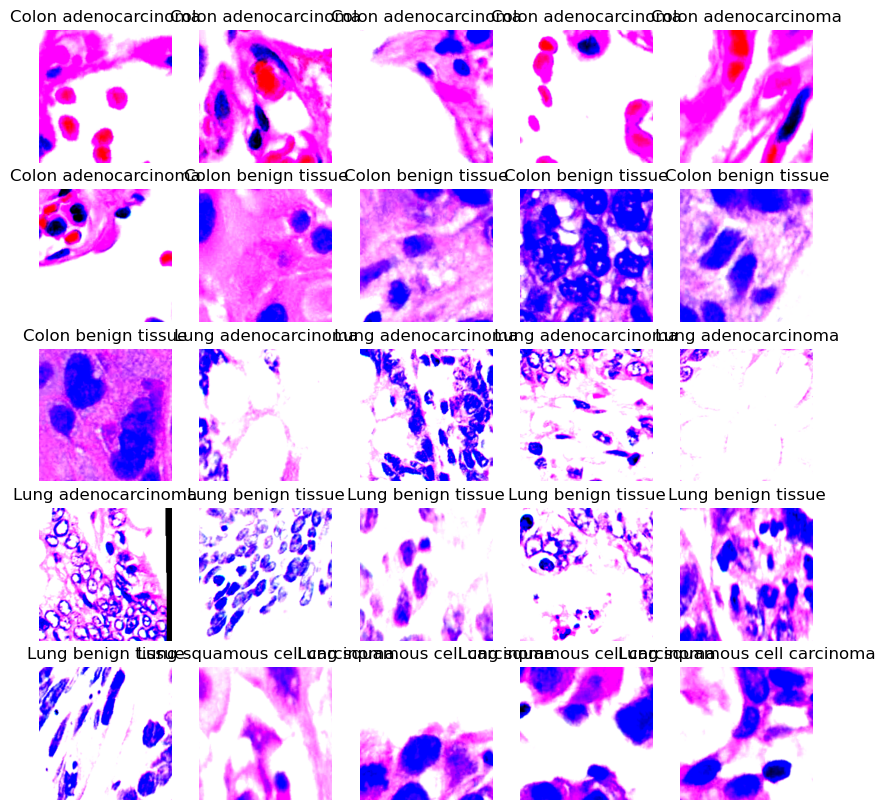

In [28]:
N_IMAGES = 25*160

images, labels = zip(*[(image, label) for image, label in 
                           [image_datasets["train"][i] for i in range(0,N_IMAGES,160)]])

class_names = image_datasets["test"].classes

plot_images(images, labels, class_names)

In [29]:
def format_label(label):
    label = label.title()
    label = label.replace(' ','')
    label = label[:-10]
    return label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

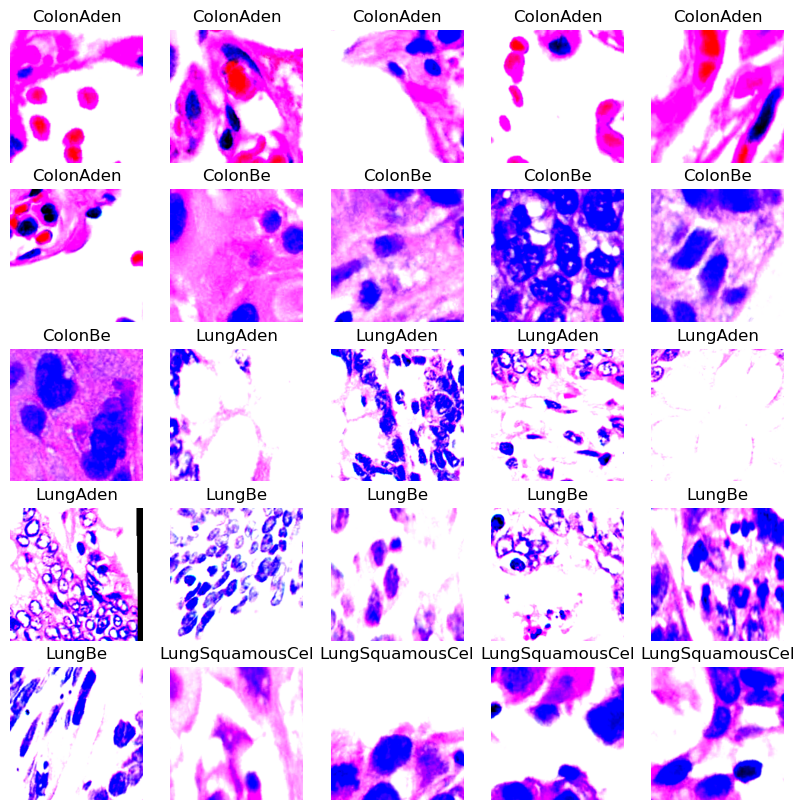

In [30]:
image_datasets["test"].classes = [format_label(c) for c in image_datasets["test"].classes]

class_names = image_datasets["test"].classes

plot_images(images, labels, class_names)

In [31]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

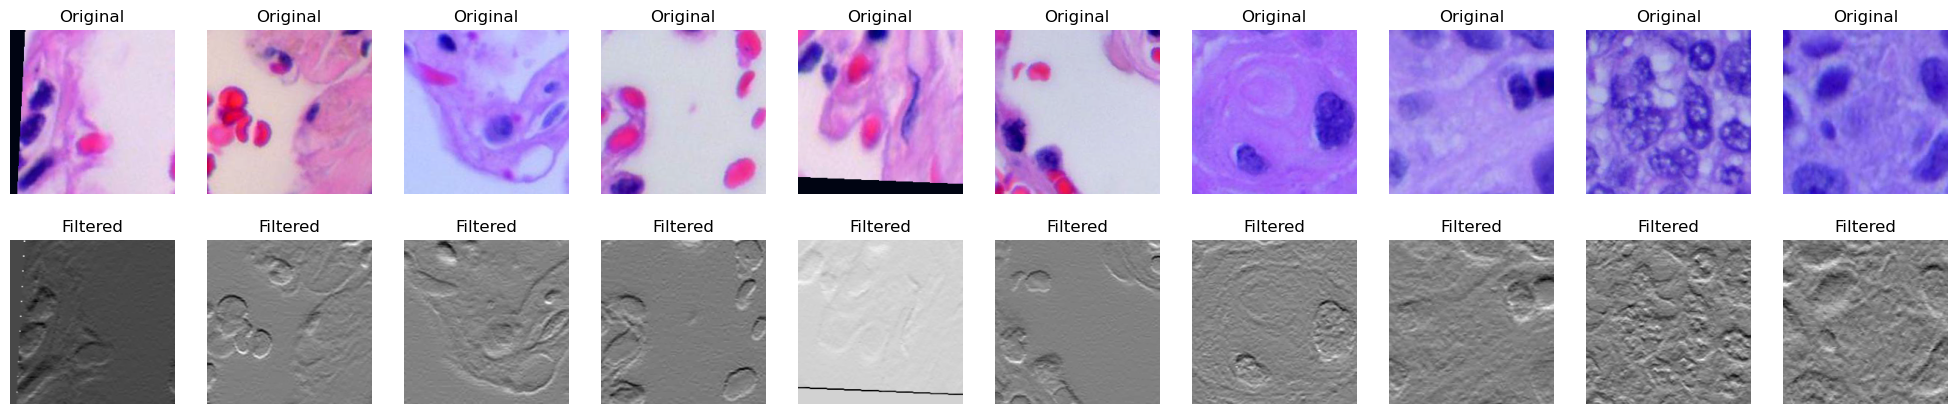

In [33]:
N_IMAGES = 10*160

images = [image for image, label in [image_datasets["train"][i] for i in range(0,N_IMAGES,160)]]

# This is a filter which detects horizontal lines.
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

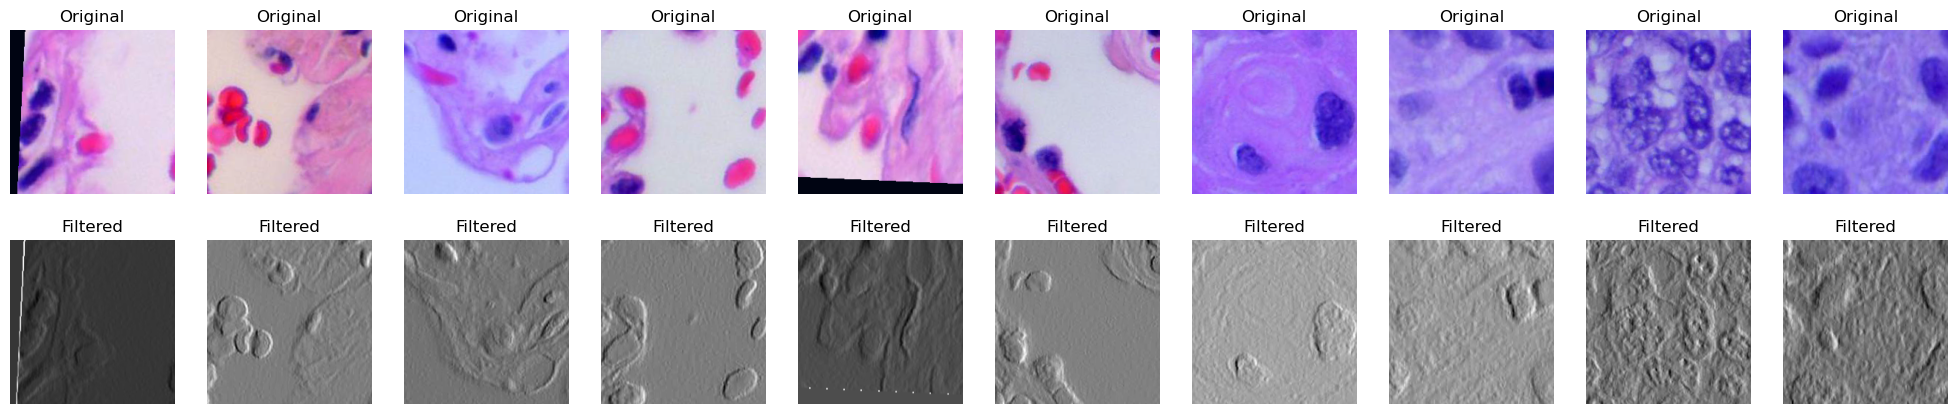

In [34]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

# This is a filter that detects vertical lines.
plot_filter(images, vertical_filter)

In [35]:
def plot_subsample(images, pool_type, pool_size, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Subsampled')
        ax.axis('off')

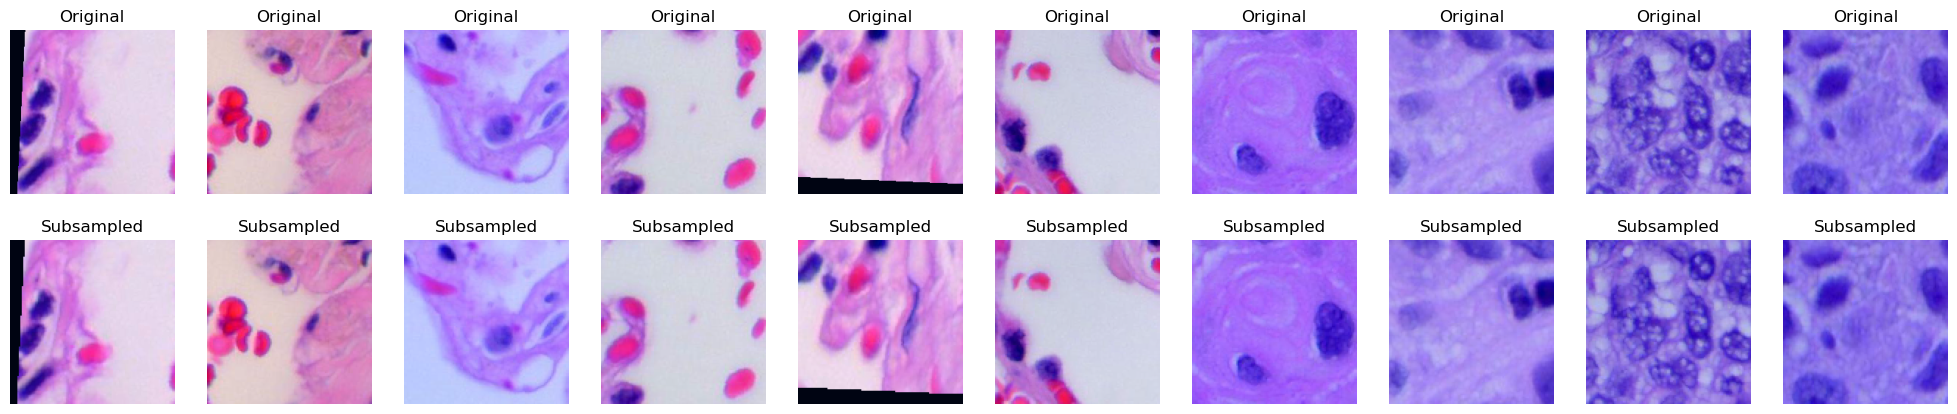

In [36]:
# The higher filter sizes in the pooling layers means more information is lost, 
# the image becomes lower resolution. 
plot_subsample(images, 'max', 2)

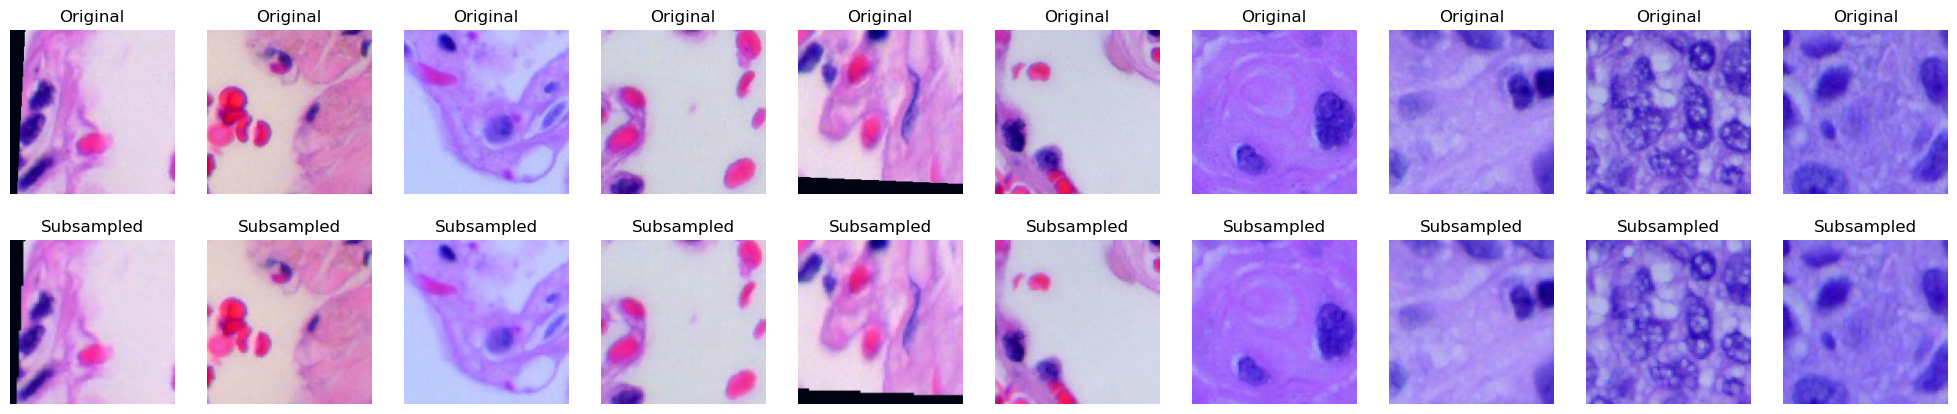

In [37]:
plot_subsample(images, 'max', 3)

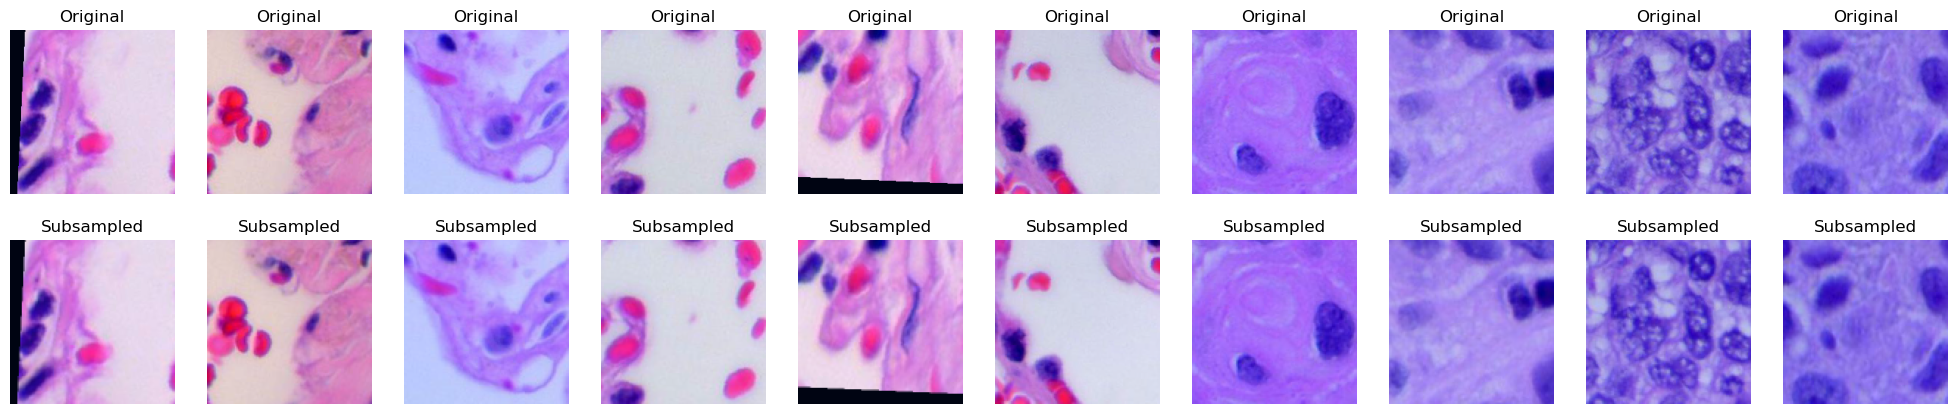

In [38]:
plot_subsample(images, 'avg', 2)

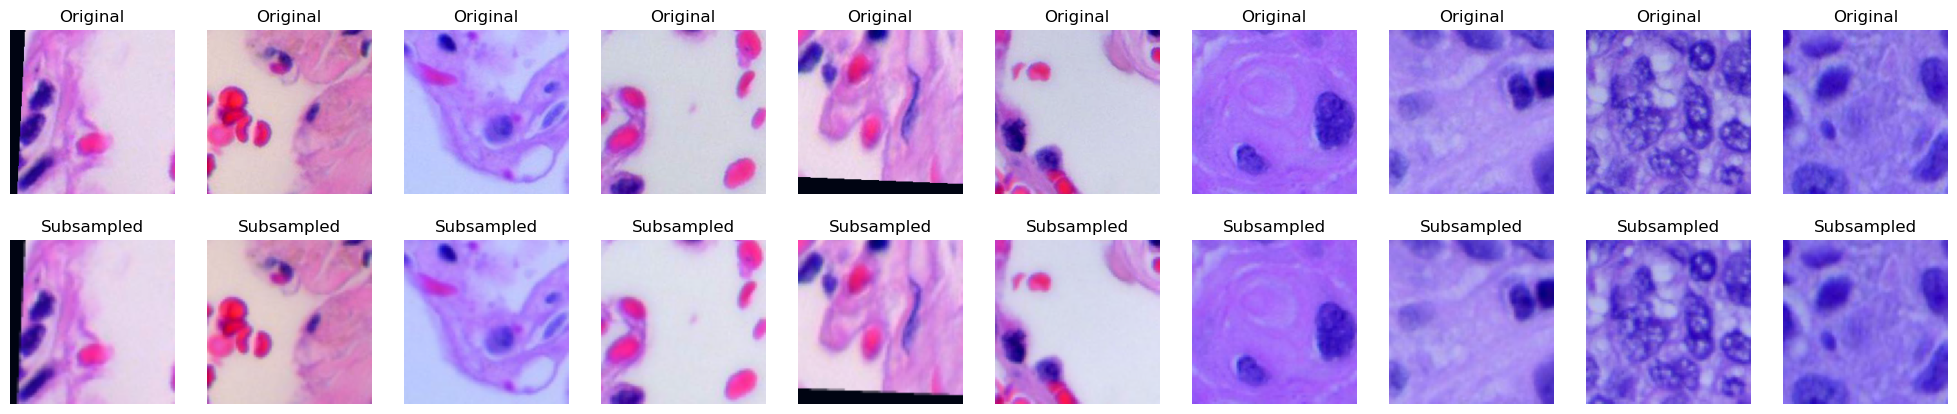

In [39]:
plot_subsample(images, 'avg', 3)

In [40]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [41]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [42]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [43]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [44]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [45]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [46]:
pretrained_model = models.resnet50(pretrained = True)

c:\Users\young\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\young\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(image_datasets["test"].classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [49]:
pretrained_model.fc = fc

In [50]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [51]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,518,277 trainable parameters


In [53]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [54]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [83]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [73]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [84]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

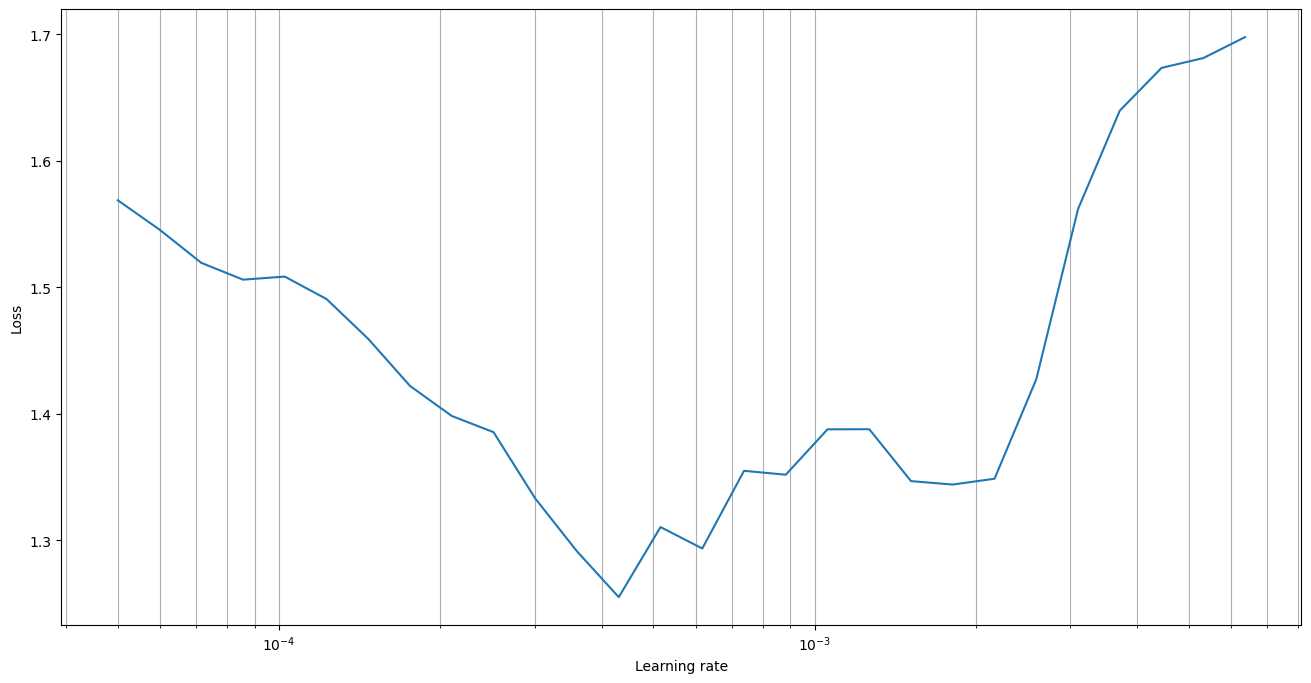

In [85]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [86]:
FOUND_LR = 4e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [93]:
import torch.optim as optim

EPOCHS = 2
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                    max_lr = MAX_LRS, 
                                    total_steps = TOTAL_STEPS)

In [88]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [89]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [90]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in tqdm(iterator):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [91]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [94]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cancer-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

100%|██████████| 113/113 [00:23<00:00,  4.88it/s]


Epoch: 01 | Epoch Time: 1m 59s
	Train Loss: 0.485 | Train Acc @1:  81.59% | Train Acc @5: 100.00%
	Valid Loss: 0.193 | Valid Acc @1:  94.03% | Valid Acc @5: 100.00%


100%|██████████| 113/113 [00:22<00:00,  5.03it/s]

Epoch: 02 | Epoch Time: 1m 54s
	Train Loss: 0.353 | Train Acc @1:  86.77% | Train Acc @5: 100.00%
	Valid Loss: 0.138 | Valid Acc @1:  94.91% | Valid Acc @5: 100.00%


In [95]:
model.load_state_dict(torch.load('cancer-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

100%|██████████| 125/125 [00:26<00:00,  4.68it/s]

Test Loss: 0.131 | Test Acc @1:  94.80% | Test Acc @5: 100.00%


In [96]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [97]:
images, labels, probs = get_predictions(model, test_loader)

In [98]:
pred_labels = torch.argmax(probs, 1) # 1은 행, 0은 열